#Library and functions

In [ ]:
#--- Reproductibility ---
%env PYTHONHASHSEED=0
from numpy.random import seed
seed(42)
from tensorflow import keras
keras.utils.set_random_seed(42)
import tensorflow as tf
tf.config.experimental.enable_op_determinism()

#---
import numpy as np
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from collections import Counter
import PIL
import glob
from tqdm import tqdm
import networkx as nx

#Graphics
from scipy.stats import gaussian_kde
from scipy.stats import norm
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.preprocessing import image

#NN
from tensorflow.keras import layers, callbacks, Input
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50

#sklearn modules: evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, root_mean_squared_error

#Recurrence plots
from pyts.image import RecurrencePlot
from pyts.datasets import load_gunpoint
from mpl_toolkits.axes_grid1 import ImageGrid

env: PYTHONHASHSEED=0


2024-10-04 11:50:58.113027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 11:50:58.710484: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
def _load_image(img_path):
  img = image.load_img(img_path, target_size=(100, 100))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img

# Neural net training: regression

##Architecture

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.Conv2D(3, 3, activation='relu'),
  #keras.layers.MaxPooling2D(2),
  keras.layers.AveragePooling2D(2),
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.Conv2D(3, 3, activation='relu'),
  #keras.layers.MaxPooling2D(2),
  keras.layers.AveragePooling2D(2),
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.Conv2D(3, 3, activation='relu'),
  #keras.layers.MaxPooling2D(2),
  keras.layers.AveragePooling2D(2),
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.Flatten(),
  keras.layers.Dense(units=1024, activation='relu'),
  keras.layers.Dense(units=512, activation='relu'),
  keras.layers.Dense(units=256, activation='relu'),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer="adam")

## Training

In [ ]:
#Read all pngs from the train set
data_path = '/your/path/'
pngs = glob.glob(data_path + 'delta_*/sample*png')

ims = {}
for png in pngs:
  ims[png]=np.array(PIL.Image.open(png).convert('L'))

In [ ]:
#Questions = images
#Solutions = a parameter that generated that image

questions = np.array([each for each in ims.values()]).astype(np.float32)
solutions = np.array([float(each.split('_')[-1].split('.')[0].split('/')[1])/(1e16) for each in ims]).astype(np.float32)

In [ ]:
N_size = 100

#Train/test split (gnuplot data):
X_train, X_test, y_train, y_test = train_test_split(questions, solutions, test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(ims, solutions, test_size=0.3, random_state=42)

X_train = X_train.reshape(-1, N_size, N_size, 1)
X_test = X_test.reshape(-1, N_size, N_size, 1)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

2024-10-15 18:05:01.159648: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1120000000 exceeds 10% of free system memory.
2024-10-15 18:05:01.789831: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1120000000 exceeds 10% of free system memory.


Epoch 1/300


2024-10-15 18:05:02.292729: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1120000000 exceeds 10% of free system memory.
I0000 00:00:1729026304.803767   68460 service.cc:145] XLA service 0x7fa460004e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729026304.803792   68460 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-10-15 18:05:04.877589: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 18:05:05.199714: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 15/280 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2477

I0000 00:00:1729026307.661199   68460 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0505 - val_loss: 0.0033
Epoch 2/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 3/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 4/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/300
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 12/300
280/280 ━━━━━━━━━━━━━━━━━━━━

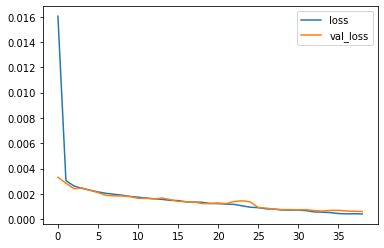

In [ ]:
#0<k<1
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

2024-09-24 19:17:28.429104: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1120080000 exceeds 10% of free system memory.
2024-09-24 19:17:29.114928: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1120080000 exceeds 10% of free system memory.


Epoch 1/300


2024-09-24 19:17:29.642268: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1120080000 exceeds 10% of free system memory.
I0000 00:00:1727216252.429493  109878 service.cc:145] XLA service 0x7fc06c027c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727216252.429528  109878 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-09-24 19:17:32.483083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-24 19:17:32.773570: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 13/281 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9686

I0000 00:00:1727216254.992043  109878 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.2536 - val_loss: 0.0272
Epoch 2/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0225 - val_loss: 0.0113
Epoch 3/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0108 - val_loss: 0.0096
Epoch 4/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 5/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 6/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 7/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 8/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 9/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 10/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 11/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 12/300
281/281 ━━━━━━━━━━━━━━━━━━━━

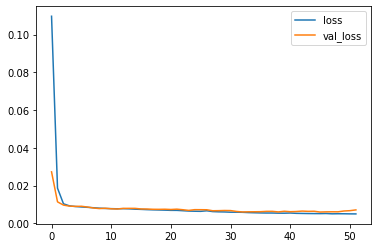

In [ ]:
#0<k<2
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

##Testing

In [ ]:
data_path = '/your/path/'
test_pngs = glob.glob(data_path + 'test/sample*png')
test_ims = {}

for png in test_pngs:
  test_ims[png]=np.array(PIL.Image.open(png).convert('L'))


#Prepare test questions and solutions as before:
test_questions = np.array([each for each in test_ims.values()]).astype(np.float32)
test_solutions = np.array([float(each.split('_')[-1].split('.')[0].split('/')[2])/(1e16)
                            for each in test_ims]).astype(np.float32)
#test_solutions = np.array([float(each.split('_')[-1].split('.')[0].split('/')[1])/(1e16) for each in test_ims]).astype(np.float32)


#Apply model:
test_answers = model.predict(test_questions)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
